# SVD (Singular Value Decomposition)

What we will cover in this page:
- Increasing importance of linear algebra
- Singular Value Decomposition (SVD)
- Using SVD to compress images
- Recommender using SVD
- SVD for linear regression
- Naive SVD algorithm

## Increasing importance of linear algebra

In 1844 Hermann Grassmann published his "Theory of Extension" which included foundational new topics of what is today called **linear algebra**. In 1848, James Joseph Sylvester introduced the term **matrix**, which is Latin for womb.
Linear algebra is the branch of mathematics concerning linear equations such as
$a_{1}x_{1}+\cdots +a_{n}x_{n}=b$ and linear functions such as $(x_{1},\ldots ,x_{n})\mapsto a_{1}x_{1}+\ldots +a_{n}x_{n}$
and their representations through **matrices and vector spaces**. Linear algebra is increasing in importance as a core tool in the AI field. Nice [podcast](https://lexfridman.com/gilbert-strang/) about this increasing importance, Strang even suggests to replace calculus by linear algebra in schools. By the way most calculus operations have discrete analogues in linear algebra.

### Linear algebra (missing pieces?)

Since you know linear algebra well I just want to point out some important things which often are left forgotten:
- Algebra has geometric interpretation
- Usually you can think about algebraic objects and operations in alternative ways and that can open up some doors

Here are a couple examples to prove these points and give you some intuition.

#### Matrix-vector multiplication

- Matrix is a collection of vectors
- A matrix maps one vector to another vector
- Matrix times vector can be thought of as a weighted sum of matrix columns

<img src="https://eli.thegreenplace.net/images/2015/veccomb.png" alt="Matrix times vector" style="width: 50%"/>
<img src="https://eli.thegreenplace.net/images/2015/vecrowcomb.png" alt="Vector times matrix" style="width: 50%"/>

So if we multiply a space by a matrix it enables us to **stretch and rotate** original space.

<img src="https://i.ytimg.com/vi/XkY2DOUCWMU/maxresdefault.jpg" alt="Space deformation" style="width: 50%"/>

For example

$$
\begin{bmatrix}
\cos(\theta) & -\sin(\theta)\\
\sin(\theta) & \cos(\theta)
\end{bmatrix}
$$

works as a simple counter-clockwise rotation, and it's inverse as clockwise rotation. For more geometric interpretations see **3Blue1Brown** [linear algebra](https://www.youtube.com/watch?v=kjBOesZCoqc&feature=emb_title) course.

### Eigenvectors

**Suggested reading:** [THE $25,000,000,000 EIGENVECTOR THE LINEAR ALGEBRA BEHIND GOOGLE](https://www.math.arizona.edu/~glickenstein/math443f08/bryanleise.pdf)

So if a vector multiplied by a matrix is a stretch and rotation, then axes of rotation can be especially useful. These axes are called eigenvectors and are easy to define, we just formalize the fact that rotation does nothing by $A u=\lambda u$, where $\lambda$ is a scalar (eigenvalue).

An eigenvector (eigen means ‘specific’ in German) is a vector whose direction remains unchanged when a linear transformation is applied to it.

In [2]:
import numpy as np

B = np.array([[-1, 1],
              [0, -2]])

values, vectors = np.linalg.eig(B)
print(f'Eigenvalues:\n{values}\nEigenvectors:\n{vectors}')

Eigenvalues:
[-1. -2.]
Eigenvectors:
[[ 1.         -0.70710678]
 [ 0.          0.70710678]]


Let's see what's going on here.

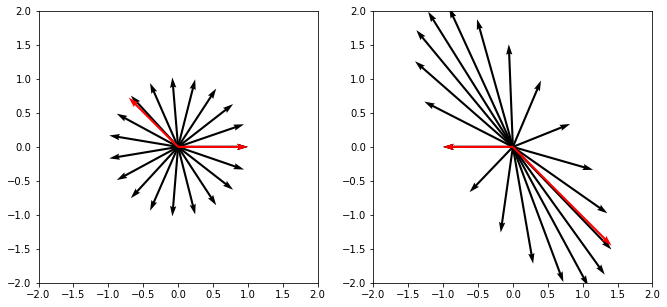

In [3]:
import matplotlib.pyplot as plt

X, Y = np.zeros(22), np.zeros(22)
U = np.concatenate([np.cos(np.linspace(0, 2*np.pi, 20)), vectors[0]])
V = np.concatenate([np.sin(np.linspace(0, 2*np.pi, 20)), vectors[1]])
colors = ['black'] * 20 + ['red'] * 2

plt.figure(figsize=(11, 5))
plt.subplot(121)
plt.quiver(X, Y, U, V, scale_units='x', scale=1, color=colors)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

U_proj, V_proj = B.dot(np.vstack([U, V]))

plt.subplot(122)
plt.quiver(X, Y, U_proj, V_proj, scale_units='x', scale=1, color=colors)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

**TASK:** play a bit and make sure that it works as expected and you can use basic *numpy* functions easily (for example *np.dot*), we will need it a lot in the future.

**TASK:** play with a matrix 
$\begin{bmatrix}
3 & 1\\
1 & 2
\end{bmatrix}$, 
can you tell what it does to the vector space and where eigenvectors are located? Do they have a clear interpretation? 

Some of the things you might discover will work only for symmetric matrices (those which are equal to its own transpose). Keep that in mind, later we will intentionally produce symmetric matrices.

### How to calculate eigenvectors

You might know that already, but let's run through a quick example to get some intuition. Let

$$A = \begin{bmatrix}
2 & 3\\
2 & 1
\end{bmatrix}$$

Since we are solving for $A u=\lambda u$ it is the same as to request that $A - \lambda I = 0$ or

$$\det\begin{pmatrix}
2 - \lambda & 3\\
2 & 1 - \lambda
\end{pmatrix} = 0.$$

After solving it you end up with two eigenvalues $\lambda_1 = -1$ and $\lambda_2 = 4$. The eigenvalue specifies the size of the eigenvector, let's find those now. By solving system of equations defined by $Au_1 = -u_1$ you should get $u_1 = \begin{bmatrix}-1\\1\end{bmatrix}$ and $Au_2 = 4u_2$ quickly leads to $u_2 = \begin{bmatrix}3\\2\end{bmatrix}$.

**TASK:** confirm these calculations using numpy.

### Singular Value Decomposition (SVD)

We can decompose matrix any way we like, for example: $A = B + C$, $A = B \cdot C$, ... It turns out that some decompositions are useful for data compression, numerical calculations and might reveal insights into the data. SVD is defined as:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/220px-Singular_value_decomposition_visualisation.svg.png" alt="SVD" style="width: 40%"/>

For some motivation see this [video](https://www.youtube.com/watch?v=YPe5OP7Clv4) with Gilbert Strang.

It is not really clear who invented SVD, but it's clear that it happened in the 19th century. For early history see this [paper](https://www.math.ucdavis.edu/~saito/courses/229A/stewart-svd.pdf). Fun fact: Gauss used matrix decomposition in 1823.

SVD is widely used in:
- Data compression 
- Recommender systems
- Linear regressions
- NLP (natural language processing)
- PCA (principal component analysis)

We will see some examples below starting from data compression.

#### How is SVD computed?

Let's compute SVD for

$X=
\begin{bmatrix}
5 & 5\\
-1 & 7
\end{bmatrix} = USV^T.$

We start by producing symmetric matrix (you should have some intuition why we need that by now)

$$X^T X=VS^TSV^T=
\begin{bmatrix}
26 & 18\\
18 & 74
\end{bmatrix} = USV^T.$$

Now we can compute eigenvectors using determinant. Since
$\det(X^TX - \lambda I) = (\lambda - 20)(\lambda - 80)$
we have

$$X^TX - 80 I =
\begin{bmatrix}
-54 & 18\\
18 & -6
\end{bmatrix}
\rightarrow
V_1 = \frac{1}{\sqrt{10}}
\begin{bmatrix}
1\\
3
\end{bmatrix}.$$

$$X^TX - 20 I = 
\begin{bmatrix}
6 & 18\\
18 & 54
\end{bmatrix}
\rightarrow
V_2 = \frac{1}{\sqrt{10}}
\begin{bmatrix}
3\\
-1
\end{bmatrix};$$

Now we have

$$V = \frac{1}{\sqrt{10}}
\begin{bmatrix}
1 & 3\\
3 & -1
\end{bmatrix},$$

thus knowing that $XV=US$ it is easy to find

$$S =
\begin{bmatrix}
4\sqrt{5} & 0\\
0 & 2\sqrt{5}
\end{bmatrix};\;
U = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}.$$

Let's confirm our results using numpy.

In [4]:
X = np.array([[5, 5],
              [-1, 7]])

U, S, V = np.linalg.svd(X)
print(f'U\n{U}\nS\n{S}\nV\n{V}')

U
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
S
[8.94427191 4.47213595]
V
[[ 0.31622777  0.9486833 ]
 [ 0.9486833  -0.31622777]]


And to get back the original matrix we can do

In [5]:
(U * S) @ V

array([[ 5.,  5.],
       [-1.,  7.]])

**Note:** there is no need to add transpose for V since `np.linalg.svd` already returns transposed matrix. You can confirm this by typing in `np.linalg.svd?` and reading provided docs.

## Using SVD to compress images

We will use the following trick to compress images:
- Calculate SVD of an image
- Leave only top N factors in S
- Multiply matrices to obtain compressed image

<img src="https://image1.slideserve.com/2598122/svd-and-rank-k-approximations-l.jpg" alt="Rank-k approximation" style="width: 50%"/>

As we saw this should work, because S captures most relevant eigenvectors.

In [6]:
from IPython import display
from time import sleep
from PIL import Image

def plot(X):
    """Just a little helper function to get a nice image plot"""
    m = 255 if X.max() > 1 else 1
    plt.imshow(X, cmap='gray', vmin=0, vmax=m)
    plt.axis('off')

In [7]:
!curl https://raw.githubusercontent.com/trokas/ai_primer/master/img/flud.jpg --output flud.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103k  100  103k    0     0   218k      0 --:--:-- --:--:-- --:--:--  219k


Image shape (503, 800)


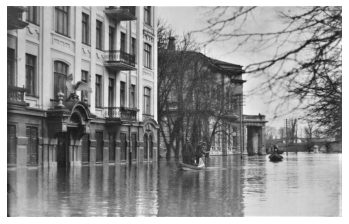

In [8]:
X = np.array(Image.open('flud.jpg').convert('L'))
print(f'Image shape {X.shape}')
plot(X)

In [9]:
def size(u, s, v):
    """Calculate number of values in SVD"""
    return u.shape[0] * u.shape[1] + s.shape[0] + v.shape[0] * v.shape[1]

n = X.shape[0] * X.shape[1]

First, let's use all singular values. Even then we reach some compression!

U shape - (503, 503)
S shape - (503,)
V shape - (800, 800)


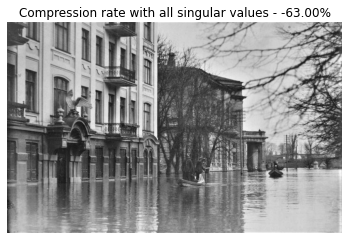

In [10]:
U, S, V = np.linalg.svd(X)
print('U shape - {0}\nS shape - {1}\nV shape - {2}'.format(U.shape, S.shape, V.shape))
plot((U * S).dot(V[:len(S)]))
plt.title('Compression rate with all singular values - {0:.02%}'.format(
    1 - size(U, S, V[:len(S)]) / n))
plt.show()

**TASK:** check if all values of `(U * S).dot(V[:len(S)])` match `X` using numpy.

Let's try to use only top singular values thus compressing the image even more.

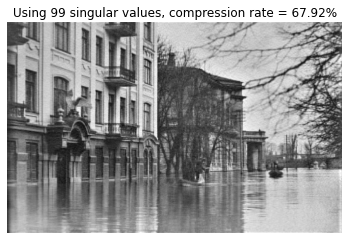

<Figure size 432x288 with 0 Axes>

In [11]:
for i in range(1, 100, 1):
    u = U[:,:i]
    s = S[:i]
    v = V[:i]
    plot((u * s).dot(v))
    plt.title('Using {0} singular values, compression rate = {1:.02%}'.format(
        i, 1 - size(u, s, v) / n))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf().clear()

Note, that first singular values capture most of the information and thus lead to high compression rate.

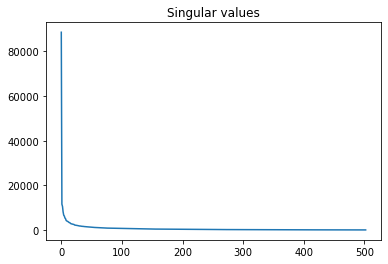

In [12]:
plt.plot(S)
plt.title('Singular values')
plt.show()

**TASK:** play with animation and explore U, S, V, how many numbers do you need to transmit comprehensible image?

## SVD for linear regression

As you might know inverses are computationally unstable, for example:

In [13]:
from scipy.linalg import hilbert

X = hilbert(10)

For sure we expect $(X^{-1})^{-1} = X$, but

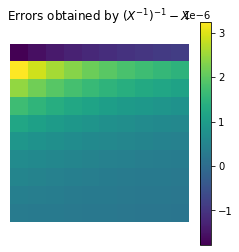

In [14]:
plt.matshow(np.linalg.inv(np.linalg.inv(X)) - X)
plt.title('Errors obtained by $(X^{-1})^{-1} - X$')
plt.axis('off')
plt.colorbar()
plt.show()

Further computations might lead to even higher errors, for example we would expect $X^{-1} X v = v$.

In [15]:
v = np.ones(10)
print(np.linalg.inv(X).dot(X).dot(v) - v)

[ 0.00046553 -0.0022208   0.0002307   0.0115333  -0.02372203  0.02033834
 -0.00750237  0.00029245  0.00066456 -0.00013716]


Linear regression works by

$$y=X\hat\beta$$

$$X^Ty=X^TX\hat\beta$$

$$\hat \beta = (X^T X)^{-1} X^T y$$

By the way you can vizualize linear regression as the process of minimizing $e$ in

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQXvIwYtFpyuHEa_0zYoECXKp3JRdf6Q89eo3Prpw9SvJBJoLmC" alt="Linear regression" style="width: 40%"/>

thus it's an analogue of finding a projection of the target vector in a given vector space.

Let's come back to our problem - we saw that the inverse is unstable... SVD is one of the solutions to deal with that problem.

Since $X=USV^T$ and $UU^T=I_m;\;VV^T=I_n$ it is easy to show that $\hat \beta = (X^T X)^{-1} X^T y = V S^{-1} U^T y.$

**Note:** the inverse of S is known to be stable.

Let's see if this trick really works on a real dataset.

In [16]:
from sklearn.datasets import load_diabetes

X = load_diabetes().data
y = load_diabetes().target
print(X.shape, y.shape)
n, m = X.shape
# add ones to dataset 
X = np.hstack([np.ones(n)[:, np.newaxis], X])
# calculate beta using direct inverse
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

(442, 10) (442,)


Calculate beta using direct inverse

In [17]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print('RMSE = {0}'.format(np.mean((X.dot(beta) - y)**2)))

RMSE = 2859.6903987680657


Calculate using SVD

In [18]:
U, S, V = np.linalg.svd(X)
S = np.hstack([np.diag(S), np.zeros((len(S), n - len(S)))]).T    # X ~ U.dot(S).dot(V)
beta_svd = V.T.dot(np.linalg.pinv(S)).dot(U.T).dot(y)
print('RMSE = {0}'.format(np.mean((X.dot(beta_svd) - y)**2)))

RMSE = 2859.6903987680657


**Note:** sklearn and most other libraries use SVD for regression.

In [19]:
from sklearn.linear_model import LinearRegression

X = load_diabetes().data   # we do not need to add 1's column now
lr = LinearRegression()
lr.fit(X, y)
pred = lr.predict(X)
print('RMSE = {0}'.format(np.mean((pred - y)**2)))

RMSE = 2859.6903987680657


**TASK:** look at the diabetes dataset, can you beat current result by some simple feature engineering? Or maybe we do not need all of the features?

### PCA (Principal Component analysis)

Similarly as with images SVD can be used to reveal most important components of the given dataset and thus lead to data compression. The process is called Principal Component analysis (PCA) as is executed as follows:

1. Make sure that your dataset has samples in rows and variables in columns.
2. Subtract mean and divide by standard deviation to normalize each variable to get $X$. To be fair subtracting mean is sufficient, but working with standard scaling is a good practice.
3. Calculate SVD by computing $X=USV^T$.
4. Treat $V$ are principal directions/axes and $US$ are principal components/scores.

**NOTE:** make sure that you can explain why each step is needed. If you need more explanation, read through this [discussion](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca), it contains some good links too.

This is a neat trick if we want to apply simple model (for example linear regression) on high dimensional datasets.



In [20]:
X = (X - X.mean(axis=0)) / X.std(axis=0)    # this is called Standard Scaling
U, S, V = np.linalg.svd(X)

i = 4
U[:,:i] * S[:i]    # principal components

array([[-0.58720767, -1.94682793,  0.58923299, -0.0828117 ],
       [ 2.83161209,  1.37208454,  0.02791506, -0.46999935],
       [-0.27214757, -1.63489803,  0.73927034, -0.79147497],
       ...,
       [ 0.20524634, -1.20544647,  0.4960784 , -1.35334928],
       [-0.69286627,  0.21011694, -0.86872976,  1.61678966],
       [ 1.90393365,  3.97577106, -0.04838108, -0.22061154]])

Just to confirm that we interpreted SVD correctly this is sklearn implementation of PCA.

In [21]:
from sklearn.decomposition import PCA

pca = PCA(4)
pca.fit(X)
pca.transform(X)

array([[ 0.58720767, -1.94682793,  0.58923299, -0.0828117 ],
       [-2.83161209,  1.37208454,  0.02791506, -0.46999935],
       [ 0.27214757, -1.63489803,  0.73927034, -0.79147497],
       ...,
       [-0.20524634, -1.20544647,  0.4960784 , -1.35334928],
       [ 0.69286627,  0.21011694, -0.86872976,  1.61678966],
       [-1.90393365,  3.97577106, -0.04838108, -0.22061154]])

For our simple dataset PCA does not help to improve RMSE, but keep this in your toolbox for those case where you have high number of correlated features. Also it can be used to plot high dimensional datasets by projecting them to lower dimension. Let's take a look.

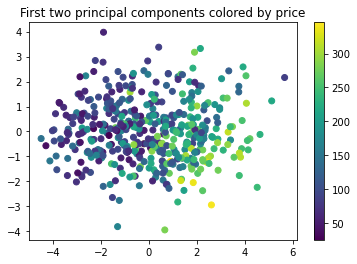

In [22]:
pca = PCA(2)
pca.fit(X)
X_proj = pca.transform(X)

plt.scatter(X_proj[:,0], X_proj[:,1], c=y)
plt.title('First two principal components colored by price')
plt.colorbar()
plt.show()

**TASK:** PCA can be used as anomaly detection simply by looking at the reconstruction error. Try to test this out using Olivetti faces dataset (`sklearn.datasets.fetch_olivetti_faces`). Just flip one or couple of images upside down so that they would look like anomalies, then encode and decode using PCA.

**TASK:** Make sure that you can repeat same exercise using SVD directly. Convince yourself that the last line of the code creates inverse transform.

```python
avg_face = X.mean(axis=0)    # Average face

U, S, V = np.linalg.svd((X - avg_face).T)   # We transpose so that image spans a column

i = 20                    # Number of components
face_to_encode = X[0]     # You can take any image here (for example: try to flip it using X[0][::-1])
encoded = U[:,:i].T @ (face_to_encode - avg_face)      # Here we encode image from 64x64 to only 20 values!
decoded = avg_face + U[:,:i] @ encoded     # This should be similar to face_to_encode
```

In essence we create a base of images in U that are used for encoding and decoding. If you take high number of components `U[:,:i] @ U[:,:i].T` will get close to identity, but when number of components is small it preserves only most relevant info. This is similar to Fourier transform, just that the base to use is suggested by the data. By the way, if you have big datasets you might need to use `sklearn.utils.extmath.randomized_svd` instead of `np.linalg.svd` to get decent run times.

**TASK:** Download the extended Yale faces dataset using the code provided below. Take the first face and leave it aside for testing (don't show it for the encoder while fitting it). Use PCA (or randomized SVD) and fit provided data. Check how it works on the image you have set aside. How many components do you need to get a decent reconstruction? Now comes the fun part - download [cropped dog](https://raw.githubusercontent.com/trokas/ai_primer/master/img/dog_crop.jpg) and [full dog](https://raw.githubusercontent.com/trokas/ai_primer/master/img/dog_full.jpg) images and try to encode and decode them using a different number of components. Which of those is easier to reconstruct? How many components do you need?

```python
!curl https://raw.githubusercontent.com/trokas/ai_primer/master/img/CroppedYale.zip --output CroppedYale.zip
!unzip CroppedYale.zip
X = np.array([np.asarray(Image.open(path)) for path in glob.glob('CroppedYale/*/*E*.pgm')])
```
Originally dataset was hosted on http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip.

---

**Solution (to the last TASK)**

```python
import glob
from sklearn.utils.extmath import randomized_svd

X = np.array([np.asarray(Image.open(path)) for path in glob.glob('CroppedYale/*/*E*.pgm')])
X = X.reshape((2414, 192 * 168))

avg_face = X.mean(axis=0)     # Average face
U, S, V = randomized_svd((X - avg_face).T, n_components=2000)

k = 600  # play with number of values
dog = np.array(Image.open('dog_crop.jpg').convert('L'))   # try to change to dog_full.jpg

face_to_encode = dog.flatten()
encoded = U[:, :k].T @ (face_to_encode - avg_face)
decoded = avg_face + U[:, :k] @ encoded

plot(face_to_encode.reshape(192, 168))
plt.show()
plot(decoded.reshape(192, 168))
```

## Recommender using SVD

In [23]:
def display(X):
    return pd.DataFrame(X).style.format("{:.2f}").background_gradient()

In [24]:
import pandas as pd

df = pd.DataFrame([[1,1,1,0,0], [3,3,3,0,0], [4,4,4,0,0], [5,5,5,0,0], [0,0,0,4,4], [0,0,0,5,5],
                   [0,0,0,2,2]], columns=['Matrix', 'Alien', 'Serenity', 'Casablanca', 'Amelie'])
display(df)

,Matrix,Alien,Serenity,Casablanca,Amelie
0,1.00,1.00,1.00,0.00,0.00
1,3.00,3.00,3.00,0.00,0.00
2,4.00,4.00,4.00,0.00,0.00
3,5.00,5.00,5.00,0.00,0.00
4,0.00,0.00,0.00,4.00,4.00
5,0.00,0.00,0.00,5.00,5.00
6,0.00,0.00,0.00,2.00,2.00


In [25]:
U, S, V = np.linalg.svd(df)

In [26]:
display(U)

,0,1,2,3,4,5,6
0,-0.14,0.00,0.00,0.99,-0.00,-0.00,0.00
1,-0.42,0.00,-0.87,-0.06,-0.04,0.25,-0.03
2,-0.56,0.00,0.29,-0.08,-0.77,-0.08,0.01
3,-0.70,0.00,0.29,-0.10,0.64,-0.08,0.01
4,0.00,-0.60,-0.18,0.00,0.00,-0.70,-0.36
5,0.00,-0.75,0.18,0.00,0.00,0.63,-0.09
6,0.00,-0.30,-0.09,0.00,0.00,-0.20,0.93


In [27]:
display(S)

,0
0,12.37
1,9.49
2,0.00
3,0.00
4,0.00


In [28]:
display(V)

,0,1,2,3,4
0,-0.58,-0.58,-0.58,-0.00,-0.00
1,-0.00,-0.00,-0.00,-0.71,-0.71
2,0.00,0.00,0.00,-0.71,0.71
3,-0.82,0.41,0.41,-0.00,-0.00
4,-0.00,0.71,-0.71,-0.00,-0.00


In [29]:
display(U[:,:2])   # User to concept similarity

,0,1
0,-0.14,0.00
1,-0.42,0.00
2,-0.56,0.00
3,-0.70,0.00
4,0.00,-0.60
5,0.00,-0.75
6,0.00,-0.30


In [30]:
display(S[:2])      # Concept strengths

,0
0,12.37
1,9.49


In [31]:
display(V[:2])    # Movie to concept similarity

,0,1,2,3,4
0,-0.58,-0.58,-0.58,-0.00,-0.00
1,-0.00,-0.00,-0.00,-0.71,-0.71


In [32]:
display((U[:,:2] * S[:2]).dot(V[:2]))

,0,1,2,3,4
0,1.00,1.00,1.00,0.00,0.00
1,3.00,3.00,3.00,0.00,0.00
2,4.00,4.00,4.00,0.00,0.00
3,5.00,5.00,5.00,0.00,0.00
4,0.00,0.00,0.00,4.00,4.00
5,0.00,0.00,0.00,5.00,5.00
6,0.00,0.00,0.00,2.00,2.00


What if we add some noise?

In [33]:
df = pd.DataFrame([[1,1,1,0,0], [3,3,3,0,0], [4,4,4,0,0], [5,5,5,0,0], [0,2,0,4,4], [0,0,0,5,5],
                   [0,1,0,2,2]], columns=['Matrix', 'Alien', 'Serenity', 'Casablanca', 'Amelie'])
display(df)

,Matrix,Alien,Serenity,Casablanca,Amelie
0,1.00,1.00,1.00,0.00,0.00
1,3.00,3.00,3.00,0.00,0.00
2,4.00,4.00,4.00,0.00,0.00
3,5.00,5.00,5.00,0.00,0.00
4,0.00,2.00,0.00,4.00,4.00
5,0.00,0.00,0.00,5.00,5.00
6,0.00,1.00,0.00,2.00,2.00


In [34]:
U, S, V = np.linalg.svd(df)

In [35]:
display(U[:,:3])   # User to concept similarity

,0,1,2
0,-0.14,-0.02,-0.01
1,-0.41,-0.07,-0.03
2,-0.55,-0.09,-0.04
3,-0.69,-0.12,-0.05
4,-0.15,0.59,0.65
5,-0.07,0.73,-0.68
6,-0.08,0.30,0.33


In [36]:
display(S[:3])      # Concept strengths

,0
0,12.48
1,9.51
2,1.35


In [37]:
display(V[:3])    # Movie to concept similarity

,0,1,2,3,4
0,-0.56,-0.59,-0.56,-0.09,-0.09
1,-0.13,0.03,-0.13,0.70,0.70
2,-0.41,0.80,-0.41,-0.09,-0.09


In [38]:
display((U[:,:3] * S[:3]).dot(V[:3]))

,0,1,2,3,4
0,1.00,1.00,1.00,0.00,0.00
1,3.00,3.00,3.00,-0.00,-0.00
2,4.00,4.00,4.00,0.00,0.00
3,5.00,5.00,5.00,0.00,0.00
4,0.00,2.00,-0.00,4.00,4.00
5,0.00,-0.00,0.00,5.00,5.00
6,0.00,1.00,-0.00,2.00,2.00


Or an approximation:

In [39]:
display((U[:,:2] * S[:2]).dot(V[:2]))

,0,1,2,3,4
0,0.99,1.01,0.99,-0.00,-0.00
1,2.98,3.04,2.98,-0.00,-0.00
2,3.98,4.05,3.98,-0.01,-0.01
3,4.97,5.06,4.97,-0.01,-0.01
4,0.36,1.29,0.36,4.08,4.08
5,-0.37,0.73,-0.37,4.92,4.92
6,0.18,0.65,0.18,2.04,2.04


### Simplest recommender

Let's add some missing ratings into the mix.

In [40]:
df = pd.DataFrame([[1,1,1,0,0], [0,3,3,0,0], [4,4,0,0,0], [5,5,5,0,0], [0,2,0,4,4], [0,0,0,5,5],
                   [0,1,0,2,2]], columns=['Matrix', 'Alien', 'Serenity', 'Casablanca', 'Amelie'])
display(df)

,Matrix,Alien,Serenity,Casablanca,Amelie
0,1.00,1.00,1.00,0.00,0.00
1,0.00,3.00,3.00,0.00,0.00
2,4.00,4.00,0.00,0.00,0.00
3,5.00,5.00,5.00,0.00,0.00
4,0.00,2.00,0.00,4.00,4.00
5,0.00,0.00,0.00,5.00,5.00
6,0.00,1.00,0.00,2.00,2.00


Trick is that SVD will tend to ignore/remove some of these 'mistakes' and end up imputing missing ratings!

In [41]:
U, S, V = np.linalg.svd(df)
display((U[:,:2] * S[:2]).dot(V[:2]))

,0,1,2,3,4
0,0.97,1.15,0.83,-0.02,-0.02
1,1.94,2.33,1.66,0.08,0.08
2,2.78,3.32,2.37,0.08,0.08
3,4.85,5.74,4.14,-0.09,-0.09
4,0.40,1.42,0.33,4.07,4.07
5,-0.43,0.63,-0.38,4.93,4.93
6,0.20,0.71,0.17,2.03,2.03


### MovieLense dataset

You can download dataset from here: https://grouplens.org/datasets/movielens/latest/

In [47]:
# !curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip --output ml-latest-small.zip
# !unzip ml-latest-small.zip

In [48]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv', index_col=0)

# Limit to top movies so that we don't run out of memory
n_movies = 1000
movie_idx_map = {v: i for i, v in enumerate(ratings.groupby('movieId').size().sort_values().tail(n_movies).index)}
ratings = ratings[ratings.movieId.isin(movie_idx_map)]

n_users = len(ratings['userId'].unique())
n_movies = len(ratings['movieId'].unique())

# Create matrix
X = np.zeros((n_users, n_movies))
for u, m, r, _ in ratings.values:
    X[int(u) - 1, movie_idx_map[int(m)]] = r

Using SVD we will extract movie to concept similarities. 

In [49]:
k = 20
U, S, V = np.linalg.svd(X)
data = pd.DataFrame(V[:k], columns=movies.loc[movie_idx_map].title)
data

title,Pay It Forward (2000),X-Men Origins: Wolverine (2009),Death Proof (2007),"Virgin Suicides, The (1999)","Lost Boys, The (1987)",Bad Santa (2003),Rocky II (1979),About Schmidt (2002),21 Jump Street (2012),Buffy the Vampire Slayer (1992),...,Schindler's List (1993),Terminator 2: Judgment Day (1991),Braveheart (1995),Jurassic Park (1993),Star Wars: Episode IV - A New Hope (1977),"Matrix, The (1999)","Silence of the Lambs, The (1991)",Pulp Fiction (1994),"Shawshank Redemption, The (1994)",Forrest Gump (1994)
0,-0.013740,-0.013834,-0.014479,-0.014837,-0.015855,-0.016608,-0.015443,-0.012657,-0.013055,-0.010631,...,-0.076227,-0.081979,-0.077771,-0.080885,-0.099899,-0.105711,-0.095243,-0.107111,-0.105981,-0.109809
1,-0.011250,-0.024457,-0.024160,0.000844,0.008939,-0.009214,0.001750,0.004903,-0.030972,0.002863,...,0.048985,0.078242,0.095468,0.092870,0.023382,-0.035287,0.075200,0.066094,0.032788,0.051767
2,0.001458,-0.007746,-0.001571,0.018164,0.021655,0.009750,0.015829,0.017258,-0.011936,0.007625,...,-0.052819,-0.080936,-0.131230,-0.105519,0.015748,-0.002344,-0.065713,-0.083778,-0.134976,-0.150658
3,-0.020321,-0.012819,-0.009553,-0.007793,-0.019447,-0.020242,-0.013159,-0.014629,-0.017410,-0.023973,...,0.140400,0.049982,0.091585,0.011390,0.060125,0.127014,0.167883,0.197865,0.203880,0.115254
4,-0.023331,0.018597,0.008455,-0.047220,-0.004637,-0.002883,0.008537,-0.013256,-0.000489,-0.002727,...,-0.072136,0.125815,0.055847,0.051397,0.139230,0.105409,-0.021655,-0.049932,-0.072611,-0.044770
5,0.018199,0.036357,0.043401,0.001917,0.012641,0.043390,0.033525,0.009536,0.038427,0.014844,...,-0.060634,-0.007255,-0.010162,-0.021724,-0.104246,-0.158481,0.006284,0.027659,-0.048065,-0.075252
6,0.001026,-0.011047,0.005113,0.009880,0.017532,0.023910,-0.020644,0.004396,-0.027700,0.005198,...,-0.037308,0.009797,0.045087,-0.020993,-0.095660,0.016492,-0.034036,0.048123,-0.014165,-0.047230
7,-0.003380,0.008470,-0.000499,0.020740,-0.012323,-0.002078,-0.004215,0.026335,-0.042955,-0.007411,...,-0.032278,0.038842,-0.010127,0.004377,-0.011656,-0.045959,-0.038364,-0.037230,-0.065388,-0.107479
8,-0.034645,-0.006897,-0.000399,-0.019876,0.012274,0.003739,-0.008065,-0.018824,0.024425,0.005707,...,-0.104706,0.029340,-0.022012,0.042776,0.051743,0.032488,0.017145,0.089404,0.002659,0.003673
9,0.015903,-0.000305,0.005696,0.043266,0.012414,-0.025808,-0.003037,-0.007873,0.030505,0.010252,...,0.023747,0.014477,0.053049,-0.039673,-0.068472,0.119593,0.020346,0.000522,-0.055144,0.070372


Now using any distance measure we can try to extract similar movies directly from V!

In [50]:
(data - data[['Toy Story (1995)']].values).pow(2).mean().sort_values().head(10)

title
Toy Story (1995)                              0.000000
Toy Story 2 (1999)                            0.002411
Nutty Professor, The (1996)                   0.002757
Twister (1996)                                0.002821
Willy Wonka & the Chocolate Factory (1971)    0.002958
Hunchback of Notre Dame, The (1996)           0.003167
Bug's Life, A (1998)                          0.003306
Multiplicity (1996)                           0.003310
Dragonheart (1996)                            0.003376
Rumble in the Bronx (Hont faan kui) (1995)    0.003380
dtype: float64

In [51]:
(data - data[['Matrix, The (1999)']].values).pow(2).mean().sort_values().head(10)

title
Matrix, The (1999)                                           0.000000
Fight Club (1999)                                            0.003215
Saving Private Ryan (1998)                                   0.003370
Gladiator (2000)                                             0.003589
Star Wars: Episode I - The Phantom Menace (1999)             0.003986
Star Wars: Episode V - The Empire Strikes Back (1980)        0.004086
Lord of the Rings: The Fellowship of the Ring, The (2001)    0.004136
Payback (1999)                                               0.004558
Memento (2000)                                               0.004605
Intouchables (2011)                                          0.004631
dtype: float64

**TASK:** naively in the recommender examples above we have not done any preprocessing. Actually it would be beneficial to remove movie bias by calculating average rating per movie, and subtracting this average from each user/movie pair. Try to add such a fix and see if that improves results. For evaluation you will need to make a train and test split.

## Naive SVD implementation

**TASK:** can you think of a simple algorithm that computes SVD? Think about that before reading on.

We know that matrix multiplication stetches and rotates the space. Try to image that you take any vector in space and repeatedly multiply it by the matrix. After some iterations this vector will align with rotation axis. Make sure you understood the claim before jumping into implementation.

One caviat is that this vector will get really long and as we know big numbers are computationaly unstable, thus we will simply normalize the vector each time. This trick is called *power itearation* and can be expressed as:

$$b_{k+1} = \frac{Ab_k}{||Ab_k||}.$$

Let's start with random matrix and compute svd using numpy.

In [60]:
n, m = 4, 3

A = np.random.normal(size=(n, m))
U, S, V = np.linalg.svd(A)

Note, that we can drop some rows/columns without loosing any valuable information.

In [61]:
k = min(n, m)
U = U[:, :k]
V = V[:k]
assert np.allclose(A, U * S @ V)

Finding the first singular value.

In [67]:
v = np.random.normal(size=m)

for _ in range(1000):
    v = A.T @ A @ v / np.linalg.norm(A.T @ A @ v)

s = np.linalg.norm(A @ v)

assert np.allclose(s, S[0])
# Note, that sign of the vector can be flipped
assert np.allclose(V[0], v) or np.allclose(V[0], -v)

**TASK:** improve run time by refactoring `A.T @ A` and repeating loop only until value of `v` becomes stable.

Also we can extract u as follows

In [69]:
u = A @ v / s

assert np.allclose(U[:, 0], u) or np.allclose(U[:, 0], -u)

Now we just need to repeat this.

In [89]:
U_approx = np.zeros((n, k))
S_approx = np.zeros(k)
V_approx = np.zeros((k, m))

# We will modify matrix, thus let's copy it first
B = A.copy()

for i in range(k):

    v = np.random.normal(size=m)
    B_temp = B.T @ B
    for _ in range(10):
        v = B_temp @ v / np.linalg.norm(B_temp @ v)

    s = np.linalg.norm(B @ v)
    u = B @ v / s     
    
    V_approx[i] = v
    S_approx[i] = s
    U_approx[:, i] = u

    # Trick is to modify original matrix by subtacting dominating component
    B -= s * np.outer(u, v)

Let's check our result

In [90]:
assert np.allclose(S_approx, S)
assert np.allclose(np.abs(V_approx), np.abs(V))
assert np.allclose(np.abs(U_approx), np.abs(U))

AssertionError: 

In [91]:
U, S, V

(array([[-0.61901597,  0.44510372,  0.51126632],
        [-0.6740068 , -0.37554582, -0.61507256],
        [ 0.09478835,  0.80135527, -0.59054837],
        [ 0.39185358, -0.13666653, -0.10744823]]),
 array([2.66995443, 1.80851629, 0.48198335]),
 array([[ 0.6880199 ,  0.06596949, -0.7226871 ],
        [ 0.71887595,  0.07421067,  0.69116579],
        [-0.09922694,  0.99505819, -0.00363454]]))

In [92]:
U_approx, S_approx, V_approx

(array([[ 0.61837371,  0.44704634, -0.51126632],
        [ 0.67454745, -0.37342639,  0.61507256],
        [-0.0959434 ,  0.80105351,  0.59054837],
        [-0.39165617, -0.13789698,  0.10744823]]),
 array([2.66995115, 1.80852112, 0.48198335]),
 array([[-0.68954819, -0.06612726,  0.72121458],
        [ 0.71741013,  0.07407011,  0.69270219],
        [ 0.09922694, -0.99505819,  0.00363454]]))

For sure there are much better algorithms to compute SVD, but I hope this naive implementation provides some intuition of why SVD and eigenvectors work the way they do.

## Conclusions 

I hope that all these examples illustrate how a relatively simple principle can have far reaching applications. Most importantly this shows that linear algebra is powerful tool and matrices hold the power to do impressive things. We will see later that neural networks are built from these concepts.

## (re)Sources

- [SVD math basics](https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491) or the [extended](https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d) version.
- [Paper - THE $25,000,000,000∗ EIGENVECTOR THE LINEAR ALGEBRA BEHIND GOOGLE](https://www.rose-hulman.edu/~bryan/googleFinalVersionFixed.pdf)
- [Video - A primer (or refresher) on linear algebra](https://youtu.be/Qz58vTa8-SY) 
- [Slides - Dimensionality Reduction PCA – SVD](https://slideplayer.com/slide/5283216/)
- [Blog - Introduction to Recommender System. Part 1 (Collaborative Filtering, Singular Value Decomposition)](https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75)
- [Blog - Image Compression with SVD](http://fourier.eng.hmc.edu/e161/lectures/svdcompression.html)
- Naive SVD algorithm was inspired by [blog post](https://towardsdatascience.com/simple-svd-algorithms-13291ad2eef2#:~:text=General%20formula%20of%20SVD%20is,columns%20are%20left%20singular%20vectors) and [wiki](https://en.wikipedia.org/wiki/Power_iteration)

For more SVD use-case examples see:
- *Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control* by J. Nathan Kutz and Steven L. Brunton.
- Fast AI [Computational Linear Algebra course](https://www.fast.ai/2017/07/17/num-lin-alg/) contains [background removal example](https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb).